# <div align="center"> Implementation of GIS-MCDA with the *r.mcda.ahp* module in GRASS GIS</div>

# 0. Sources and data

**Sources**: 
- [neteler/jupyter_sentinel2_grass_gis](https://github.com/neteler/jupyter_sentinel2_grass_gis/blob/main/sentinel2_grass_gis.ipynb)

- [tomasvsm/OBIA_GRASS](https://github.com/tomasvsm/OBIA_GRASS/blob/main/OBIA_classification_PNeo.ipynb)
- [Course GRASS GIS (Vero)](https://veroandreo.github.io/curso-grass-gis/)
- [Workshopp GRASS GIS FOSS4G](https://github.com/ncsu-geoforall-lab/grass-gis-workshop-foss4gna-2023)



**Data**: 
- Study area: [IGN](https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG) ${\to}$ Geodesia y demarcación ${\to}$ Polígono ${\to}$ Gobierno Local (gid: 1385; Cordoba)

- [Sentinel-2](https://dataspace.copernicus.eu/)
- DEM: Modelo Digital de Elevaciones (5m). IDECOR. Descargas ${\to}$ Geografia fisica ${\to}$  [DEM](https://www.mapascordoba.gob.ar/#/descargas) 5m
- [FABDEM](https://gee-community-catalog.org/projects/fabdem/): Forest And Buildings removed Copernicus 30m DEM. 

    (Córdoba: S40W070-S30W060_FABDEM_V1-2.zip ; S32W065_FABDEM_V1-2.tif)
- [Open buildings](https://sites.research.google/open-buildings/): footprints of buildings from high resolution satellite imagery. 

    (Córdoba: 943_buildings.csv.gz . En QGIS lo pasé a gpkg y reproyecté a 5346)

- [Worlpop](https://hub.worldpop.org/geodata/summary?id=25196): Unconstrained inidividual countries 2000-2020 UN adjusted (100m resolution)/ Argentina 100m. Population
- [Necesidades basicas insatisfechas](https://mapa.poblaciones.org/map/#/@-31.413038,-64.116211,12z/l=3401!v1!a2!w0): Poblaciones.org censo 2010 Argentina.

# 1. Activation of GRASS and the working environment

[Diagram of GRASS file structure](https://grass.osgeo.org/programming8/)

In [1]:
# Check GRASS instalation path
!grass --config path

/usr/lib/grass83


In [2]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

In [ ]:
# Create a new location/project
#gs.run_command("g.proj",epsg=5346,location="posgar2007_4_cba",flags="c")

In [ ]:
# Create a new mapset
#gs.run_command("g.mapset",mapset="MCDA",flags="c")

In [3]:
# Definition database, project, mapset
# Set data directory
homedir = "/home/tomas"

# GRASS GIS database variables
gisdata = os.path.join(homedir, "gisdata")
grassdata = os.path.join(homedir, "grassdata")
project = "posgar2007_4_cba"
mapset = "MCDA"


os.chdir(homedir)

In [4]:
# Start the GRASS GIS Session
session = gj.init(grassdata, project, mapset)

In [5]:
# check the CRS
print(gs.read_command("g.proj", flags="p"))

-PROJ_INFO-------------------------------------------------
name       : POSGAR 2007 / Argentina 4
ellps      : wgs84
proj       : tmerc
lat_0      : -90
lon_0      : -63
k          : 1
x_0        : 4500000
y_0        : 0
no_defs    : defined
-PROJ_SRID-------------------------------------------------
SRID       : EPSG:5346
-PROJ_UNITS------------------------------------------------
unit       : meter
units      : meters
meters     : 1



In [6]:
!g.mapset -p

MCDA


In [7]:
# histogram
# Import required libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from grass.script import array as garray
from IPython.display import Image

In [8]:
#list maps in current mapset
!g.list -m type=all

Building_height@MCDA
Building_height_0@MCDA
Buildings@MCDA
Buildings_100@MCDA
DEM_5m@MCDA
FABDEM_30m@MCDA
FABDEM_5m@MCDA
MASK@MCDA
NBI_100@MCDA
NBI_prop@MCDA
NDVI@MCDA
NDVI_100@MCDA
People_100@MCDA
building_height_max@MCDA
out_test10@MCDA
out_test11@MCDA
out_test12@MCDA
out_test13@MCDA
out_test14@MCDA
out_test7@MCDA
out_test8@MCDA
out_test9@MCDA
population_density@MCDA
s2a_B02@MCDA
s2a_B03@MCDA
s2a_B04@MCDA
s2a_B08@MCDA
s2a_NDVI@MCDA
NBI@MCDA
cba@MCDA
mask@MCDA
municipios@MCDA
open_buildings@MCDA
tile_cba_01km@MCDA


In [ ]:
#remove layers
#!g.remove -f type=raster,vector pattern="Buildings"

# 2.  Create an area of interest from a vector

In [ ]:
# Import
gs.run_command("v.import", input=homedir+"/gisdata/GIS_MCDA/municipios_arg/municipio.shp", output="municipios")

# Extract one value from vector
gs.run_command("v.extract", input="municipios", where="gid = 1385", output="cba")

# Show attributes
gs.vector_db_select('cba')['values']

In [ ]:
# buffer single tile

gs.run_command("v.buffer", input="cba", where="gid = 1385", distance="100",
               output="tile_cba_01km")

# show metadata
gs.vector_info("tile_cba_01km")

In [ ]:
# display radio_urbano_cba vector
cba_map = gj.InteractiveMap(width = 400, use_region=True, tiles="OpenStreetMap")
cba_map.add_vector("tile_cba_01km")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
## guardar el vector como archivo
gs.run_command("v.out.ogr",
               input="tile_cba_01km",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/vbles_sin_cat/tile_cba_1km.gpkg")

In [ ]:
# set as computational region
# set the computational region to the extent of Cordoba urban area
gs.run_command("g.region",
               vector="tile_cba_01km",
               flags="p")

## Mask

In [ ]:
# Import mask
gs.run_command("v.import", input="/home/tomas/gisdata/GIS_MCDA/MaskUrban_Cba2019_Landsat08.gpkg", output="mask")

In [ ]:
!r.mask vector=mask

# 3. Sentinel-2 processing

#### <p style="color:red;"> To do:</p> 
<p style="color:red;">Definir la fecha de la imagen sentinel-2 que queremos usar. </p>

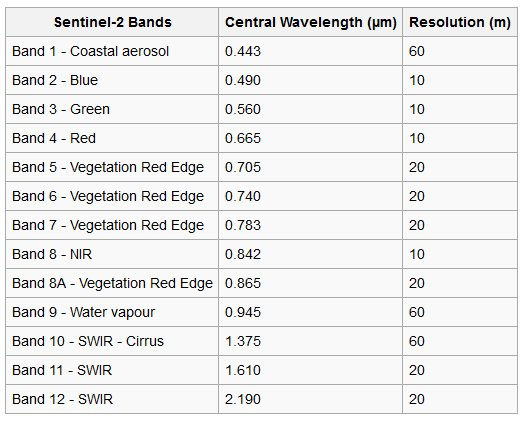

## 3.1. Select and download of Sentinel-2 data (i.sentinel)  (Addon does not work)

In [ ]:
#!pip install sentinelsat

In [ ]:
#gs.run_command("g.extension", extension="i.sentinel")

[Manual i.sentinel.download](https://grass.osgeo.org/grass83/manuals/addons/i.sentinel.download.html)

In [ ]:
# list available Sentinel-2 L2A scenes for AOI
# note that we use parse_command() in order to intercept the output for display in the browser
"""gs.parse_command("i.sentinel.download", 
                 flags="l",
                 map="tile_cba_1km", 
                 producttype="S2MSI2A",
                 settings=homedir+"/gisdata/esa_credentials.txt",
                 start="2020-03-01", 
                 end="2020-04-30", 
                 clouds="30",
                 sort="cloudcoverpercentage",
                 footprints="s2_footprints",
                 area_relation="Contains")"""


In [ ]:
# download selected scene
"""s2_data = os.path.join(homedir, "gisdata", "s2_data")

gs.run_command("i.sentinel.download", 
               settings=homedir+"/gisdata/esa_credentials.txt", 
               uuid="S2A_MSIL1C_20240324T140711_N0510_R110_T20JLL_20240324T190903.SAFE",
               output=s2_data)"""

[Manual i.sentinel.import](https://grass.osgeo.org/grass83/manuals/addons/i.sentinel.import.html)

In [ ]:
# print bands info before importing
# (1 -proj match, 0 -no proj match)
"""gs.run_command("i.sentinel.import", 
               input="/home/tomas/gisdata", 
               flags="p")"""

## 3.2. Import Sentinel-2 data (without i.sentinel)

<div> 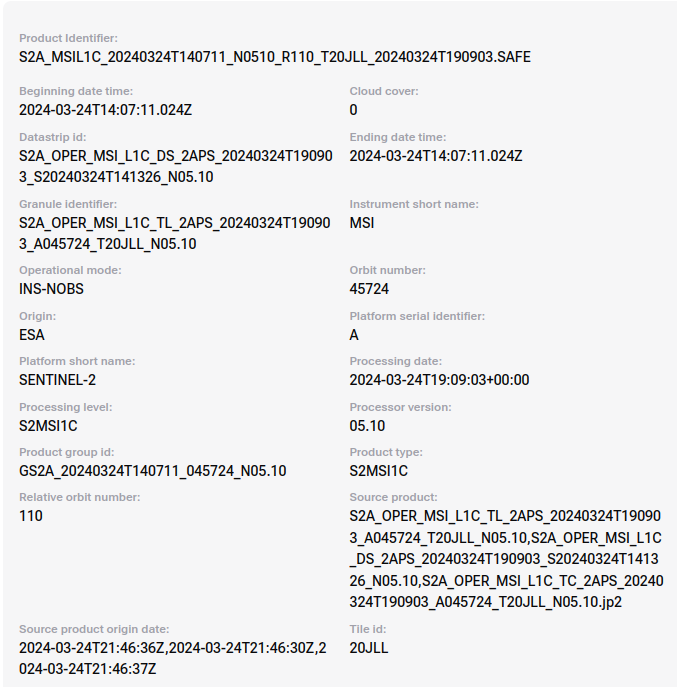</div>

In [ ]:
#directory
sentinel_data = "/home/tomas/gisdata/GIS_MCDA/s2_data/S2A_MSIL1C_20240324T140711_N0510_R110_T20JLL_20240324T190903/"

#02:B;03:G,04:R;08:NIR
#Import each band
gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B02.jp2"),
               output="s2a_B02",
               resolution="value",
               resolution_value=10,
               extent="region")

gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B03.jp2"),
               output="s2a_B03",
               resolution="value",
               resolution_value=10,
               extent="region")

gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B04.jp2"),
               output="s2a_B04",
               resolution="value",
               resolution_value=10,
               extent="region")

gs.run_command("r.import",
               input=os.path.join(sentinel_data, "T20JLL_20240324T140711_B08.jp2"),
               output="s2a_B08",
               resolution="value",
               resolution_value=10,
               extent="region")

In [ ]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=10
               )

In [ ]:
cba_blue = gj.Map(width=300, use_region=True)
cba_blue.d_rast(map="s2a_B02")
cba_blue.show()

In [ ]:
# Enhance the colors
gs.run_command("i.colors.enhance",
               red="s2a_B04",
               green="s2a_B03",
               blue="s2a_B02",
               strength="95")

In [ ]:
# Display RGB natural color using gj.Map
rgb_map = gj.Map(width=500, use_region=True)
rgb_map.d_rgb(red="s2a_B04",
              green="s2a_B03",
              blue="s2a_B02",)
rgb_map.show()

In [ ]:
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="p",
               vector="tile_cba_01km",
               align="s2a_B04",
               res=10
               )

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("s2a_B04")
cba_map.add_raster("s2a_B03")
cba_map.add_raster("s2a_B02")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

# 4. Vegetation

#### <p style="color:red;"> To do:</p> 



## 4.1. Normalized Difference Vegetation Index (NDVI)

In [ ]:
# Estimate vegetation index. 02:B;03:G,04:R;08:NIR
gs.run_command("i.vi", 
               red="s2a_B04", 
               nir="s2a_B08", 
               output="s2a_NDVI", 
               viname="ndvi")

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("s2a_NDVI", opacity=0.8)
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="s2a_NDVI")
cba_ndvi.d_legend(raster="s2a_NDVI",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="-1,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="s2a_NDVI"))

In [ ]:
#  get info and stats
gs.raster_info(map="s2a_NDVI")

## Change resolution 100m

In [ ]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=100
               )

In [ ]:
!r.resamp.stats -w input=s2a_NDVI output=NDVI method=average

In [ ]:
#  get info and stats
gs.raster_info(map="NDVI")

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="NDVI",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/vbles_sin_cat/NDVI_sincat.tif")

## NDVI with 5 categories

Considering: 

- 0: >0.8: very dense vegetation
- 0.25: 0.6 to 0.8: dense vegetation
- 0.5: <0.2: Soil without vegetation
- 0.75: 0.4 to 0.6 medium vegetation
- 1:  0.2 to 0.4: little vegetation


In [ ]:
gs.mapcalc(exp="NDVI_100=if(NDVI <= 0.2, 0.5, if(NDVI <= 0.4, 1, if(NDVI <= 0.6, 0.75, if(NDVI <= 0.8, 0.25, if(NDVI > 0.8, 0)))))")

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="NDVI"))

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="NDVI_100")
cba_ndvi.d_legend(raster="NDVI_100",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="0,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
#  get info and stats
gs.raster_info(map="NDVI_100")

### Save

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="NDVI_100",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/NDVI_100.tif")

# 5. Buildings

Data:
- DEM: Modelo Digital de Elevaciones (5m). [IDECOR](https://www.mapascordoba.gob.ar/#/descargas) 

    Descargas ${\to}$ Geografia fisica ${\to}$  DEM 5m
- [FABDEM](https://gee-community-catalog.org/projects/fabdem/): Forest And Buildings removed Copernicus 30m DEM . 

    Tile corresponding to Córdoba: S40W070-S30W060_FABDEM_V1-2.zip ; S32W065_FABDEM_V1-2.tif
- [Open buildings](https://sites.research.google/open-buildings/): A deep learning model was trained to determine the footprints of buildings from high resolution satellite imagery. 

    Tile corresponding to Córdoba: 943_buildings.csv.gz . En QGIS lo pasé a gpkg y reproyecté a 5346.
        
Future: 

- Automated DEM download:
        
    [r.in.nasadem](https://grass.osgeo.org/grass83/manuals/addons/r.in.nasadem.html) : Creates a DEM from 1 arcsec NASADEM tiles.
        
    [r.in.srtm.region](https://grass.osgeo.org/grass83/manuals/addons/r.in.srtm.region.html) - Creates a DEM from 3 arcsec SRTM v2.1 or 1 arcsec SRTM v3 tiles.

#### <p style="color:red;"> To do:</p> 


<div> 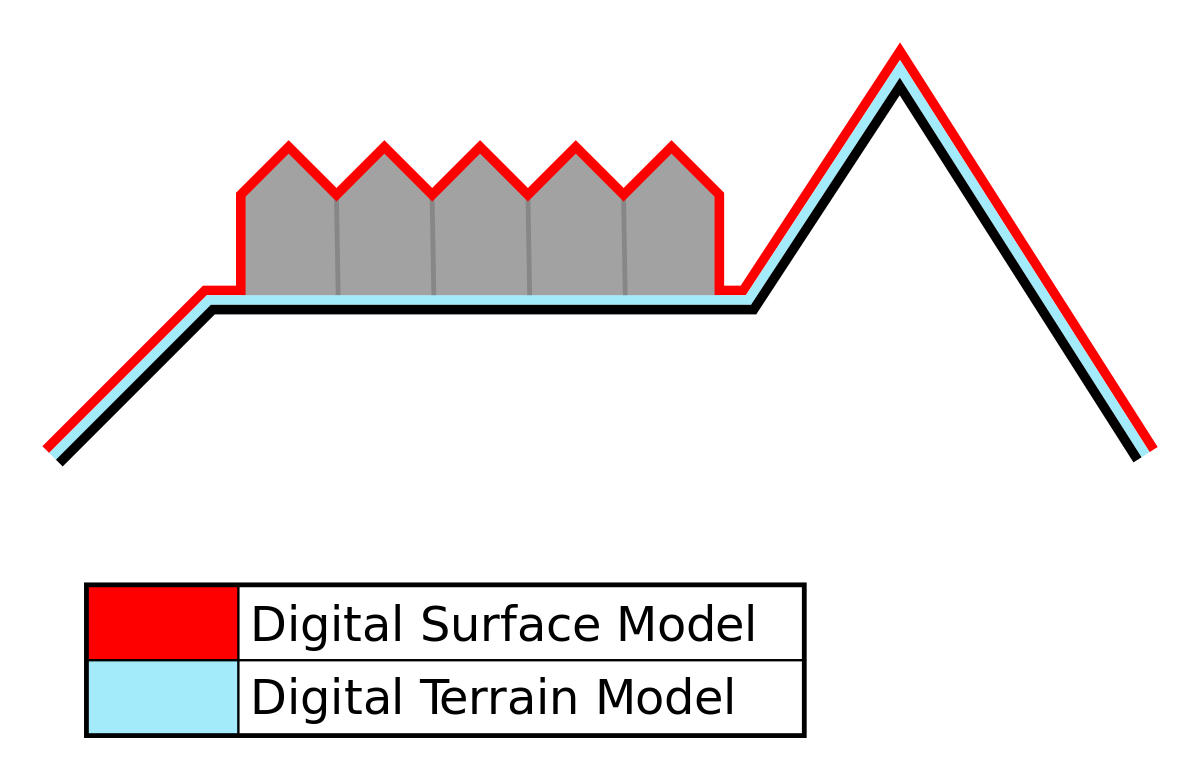</div> 

DEM (DSM. relieve+arboles+edificos) - FADBEM (DTM. solo el terreno, sin arboles y edificios) = Altura de edificaciones  --> a partir de los poligonos de open buildings sacar info sobre cada construcción --> categorizamos y agrupamos de alguna forma

## 5.1. Digital Elevation Model (DEM)

In [ ]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=5
               )

In [ ]:
#import DEM
gs.run_command("r.import",
               input=os.path.join(homedir+"/gisdata/GIS_MCDA/dem_5m_cba_ext.tif"),
               output="DEM_5m",
               resolution="value",
               resolution_value=5,
               extent="region")

In [ ]:
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="p",
               vector="tile_cba_01km",
               align="DEM_5m",
               res=5
               )

In [ ]:
# Visualize results in an interactive map
dem_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
dem_map.add_raster("DEM_5m")
dem_map.add_layer_control(position = "bottomright")
dem_map.show()

In [ ]:
# check values
print(gs.read_command("r.univar",
                      map="DEM_5m"))

## 5.2. Forest And Buildings removed Copernicus DEM (FABDEM)

In [ ]:
#import FABDEM
gs.run_command("r.import",
               input=os.path.join(homedir+"/gisdata/GIS_MCDA/S32W065_FABDEM_V1-2.tif"),
               output="FABDEM_30m",
               resolution="value",
               resolution_value=30,
               extent="region")

In [ ]:
# Visualize results in an interactive map
fabdem_map=gj.InteractiveMap(width = 400, tiles="CartoDB positron", use_region=True)
fabdem_map.add_raster("FABDEM_30m")
fabdem_map.add_layer_control(position = "bottomright")
fabdem_map.show()

In [ ]:
#  get info and stats
gs.raster_info(map="FABDEM_30m")

### Downscaling FABDEM: 30m a 5m

In [ ]:
#r.resamp.interp - Resamples raster map to a finer grid using interpolation.
!r.resamp.interp input=FABDEM_30m output=FABDEM_5m method=bilinear

In [ ]:
# Visualize results in an interactive map
fabdem_map=gj.InteractiveMap(width = 400, tiles="CartoDB positron", use_region=True)
fabdem_map.add_raster("FABDEM_5m")
fabdem_map.add_layer_control(position = "bottomright")
fabdem_map.show()

In [ ]:
#  get info and stats
gs.raster_info(map="FABDEM_5m")

## 5.3. Building height (=DEM - FABDEM)

In [ ]:
gs.mapcalc(exp="Building_height=(DEM_5m - FABDEM_5m)")

In [ ]:
# Visualize results in an interactive map
map=gj.InteractiveMap(width = 500, tiles="CartoDB positron", use_region=True)
map.add_raster("FABDEM_5m")
map.add_raster("DEM_5m")
map.add_raster("Building_height")
map.add_layer_control(position = "bottomright")
map.show()

In [ ]:
# check values
print(gs.read_command("r.univar",
                      map="Building_height"))

In [ ]:
# Read as numpy array
build = garray.array(mapname="Building_height", null="nan")
print(build.shape)

# Plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(figsize=(10, 4))
sns.histplot(ax=axs, data=build.ravel(), kde=True)
axs.set_title('Histograma de Building_height')
plt.show()

In [ ]:
# Replace negative values by 0
gs.mapcalc(exp="Building_height_0=if(Building_height<0,0,Building_height)")

In [ ]:
# check values
print(gs.read_command("r.univar",
                      map="Building_height_0"))

In [ ]:
# Read as numpy array
build0 = garray.array(mapname="Building_height_0", null="nan")
print(build0.shape)

# Plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(figsize=(10, 4))
sns.histplot(ax=axs, data=build0.ravel(), kde=True)
axs.set_ylim(0,100)
axs.set_title('Histograma de Building_height_0 - ylim:0,100')
plt.show()

In [ ]:
# Visualize results in an interactive map
map=gj.InteractiveMap(width = 500, tiles="CartoDB positron", use_region=True)
map.add_raster("Building_height_0")
map.add_layer_control(position = "bottomright")
map.show()

In [ ]:
#save
"""
gs.run_command("r.out.gdal",
               input="Building_height_0",
               output="/home/tomas/gisdata/GIS_MCDA/buildings/Building_height_0.tif")"""

## 5.4. Open Buildings

En qgis: pasé de csv a gpkg, reproyecté a 5346 y recorté al area de cordoba

In [ ]:
# Import
gs.run_command("v.import", input=homedir+"/gisdata/GIS_MCDA/open_buildings_cba_5346.gpkg", extent="region", output="open_buildings", epsg="5346")

In [ ]:
# to extract values of AOI (I did this in QGIS)
#v.clip

In [ ]:
# show metadata
gs.vector_info("open_buildings")

In [ ]:
!v.info map=open_buildings

In [ ]:
ob = gj.Map(width=500, use_region=True)
ob.d_vect(map="open_buildings", type="boundary", color="yellow")
ob.show()

In [ ]:
## NO ANDA

# display open_buildings vector
"""ob_map = gj.InteractiveMap(width = 1000, use_region=True, tiles="OpenStreetMap")
ob_map.add_vector("open_buildings")
ob_map.add_layer_control(position = "bottomright")
#ob_map.save("prueba.html")
ob_map.show()"""

## 5.4. Calculations

[v.rast.stats](https://grass.osgeo.org/grass83/manuals/v.rast.stats.html): Calculates univariate statistics from a raster map based on a vector map and uploads statistics to new attribute columns.

In [ ]:
# Extract the maximum height of buildings in each open buildings polygon
gs.run_command("v.rast.stats",
               map="open_buildings",
               raster="Building_height_0",
               column_prefix="building_height",
               method="maximum")

In [ ]:
# show metadata
!v.info map=open_buildings -c

In [ ]:
### Rasterise results based on the new column
gs.run_command("v.to.rast",
               input="open_buildings",
               use="attr",
               attribute_column="building_height_maximum",
               output="building_height_max",
               type="area",
               memory=12000)

In [ ]:
# check values
print(gs.read_command("r.univar",
                      map="building_height_max"))

In [ ]:
# Visualize results in an static map
cba_ndvi_reclass = gj.Map(width=500, use_region=True)
cba_ndvi_reclass.d_rast(map="building_height_max")
cba_ndvi_reclass.d_legend(raster="building_height_max", color="black",fontsize=10, 
                  at=(95,80, 3, 6))
cba_ndvi_reclass.show()

In [ ]:
# change null values (places where there are no open building polygons) to 999
#!r.null map="building_height_max" null=999

In [ ]:
# check values
#print(gs.read_command("r.univar",map="building_height_max"))

In [ ]:
# Set the color palette
gs.run_command("r.colors",
               map="building_height_max",
               color="haxby")

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("building_height_max")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
#save
"""
gs.run_command("r.out.gdal",
               input="building_height_max",
               output="/home/tomas/gisdata/GIS_MCDA/buildings/building_height_max.tif")"""

In [ ]:
#import building_height_max.tif
"""
gs.run_command("r.import",
               input=os.path.join("/home/tomas/gisdata/GIS_MCDA/buildings/building_height_max.tif"),
               output="building_height_max",
               resolution="value",
               resolution_value=5,
               extent="region")"""

### Save with resolution 100m

In [ ]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=100
               )

In [ ]:
!r.resamp.stats -w input=building_height_max output=Buildings method=average

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="Buildings")
cba_ndvi.show()

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("Buildings")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="Buildings",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/vbles_sin_cat/Buildings_sincat.tif")

### Buldings con 5 categorias: 0 (no construcciones) , 0.25 (30m a max.), 0.50 (20m a 30m), 0.75 (10m a 20m), 1 (0 a 10m)

In [ ]:
#gs.mapcalc(exp="Buildings=if(building_height_max <= 10, 1, if(building_height_max <= 20, 0.75, if(building_height_max <= 30, 0.50, if(building_height_max <= 70, 0.25, if(building_height_max = null, 0)))))")
gs.mapcalc(exp="Buildings_100=if(Buildings <= 10, 1, if(Buildings <= 20, 0.75, if(Buildings <= 30, 0.50, if(Buildings <= 70, 0.25))))")

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("Buildings_100")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
# Read as numpy array
build = garray.array(mapname="Buildings_100", null="nan")
print(build.shape)

# Plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(figsize=(10, 4))
sns.histplot(ax=axs, data=build.ravel(), kde=True)
axs.set_title('Histograma de Buildings_100')
plt.show()

In [ ]:
# change null values to 0
!r.null map="Buildings_100" null=0

In [ ]:
# Read as numpy array
build = garray.array(mapname="Buildings_100", null="nan")
print(build.shape)

# Plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(figsize=(10, 4))
sns.histplot(ax=axs, data=build.ravel(), kde=True)
axs.set_title('Histograma de Buildings_100')
plt.show()

In [ ]:
#gs.mapcalc(exp="Buildings=if(building_height_max>=0&&building_height_max<=10,1,building_height_max)")
#gs.mapcalc(exp="Buildings=if(Buildings==999,0,Buildings)")
#gs.mapcalc(exp="Buildings=if(Buildings>10&&Buildings<=20,0.75,Buildings)")
#gs.mapcalc(exp="Buildings=if(Buildings>20&&Buildings<=30,0.50,Buildings)")
#gs.mapcalc(exp="Buildings=if(Buildings>30&&Buildings<=70,0.25,Buildings)")

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="Buildings_100"))

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="Buildings_100")
cba_ndvi.d_legend(raster="Buildings_100",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="0,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 500, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("Buildings_100")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
#  get info and stats
gs.raster_info(map="Buildings")

## Save

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="Buildings_100",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/Buildings_100.tif")

# 6. Human population density

#### <p style="color:red;"> To do:</p> 

In [ ]:
#import data
gs.run_command("r.import",
               input=os.path.join("/home/tomas/gisdata/GIS_MCDA/population/worlpop/unconstrained_100_2020_UNadj/arg_ppp_2020_UNadj.tif"),
               output="population_density",
               resolution="value",
               resolution_value=100,
               extent="region")

In [ ]:
#  get info and stats
gs.raster_info(map="population_density")

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="population_density"))

In [ ]:
# change null values to 0
! r.null map="population_density" null=0

In [ ]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=100
               )

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="population_density",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/vbles_sin_cat/People_sincat.tif")

### Población con: 5 categorias: 0 (0 - 10) , 0.25 (10 - 20), 0.50 (20 a 30), 0.75 (30 a 40), 1 (40 a 50 -max 56aprox)

In [ ]:
gs.mapcalc(exp="People_100=if(population_density<=10,0, if(population_density<=20,0.25, if(population_density<=30,0.50, if(population_density<=40,0.75, if(population_density>40,1, 0)))))")

In [ ]:
#gs.mapcalc(exp="People_100=if(population_density<=10,0,population_density)") 
#gs.mapcalc(exp="People_100=if(People_100>10&&People_100<=20,0.25,People_100)")
#gs.mapcalc(exp="People_100=if(People_100>20&&People_100<=30,0.50,People_100)")
#gs.mapcalc(exp="People_100=if(People_100>30&&People_100<=40,0.75,People_100)")
#gs.mapcalc(exp="People_100=if(People_100>40,1,People_100)")

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="People_100"))

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="People_100")
cba_ndvi.d_legend(raster="People_100",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="0,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="People_100",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/People_100.tif")

# 7. Socioeconomic

#### <p style="color:red;"> To do:</p> 

en qgis: hice el calculo de la division en la tabla de atributos: h_nbi / h_total para agregar el campo "NBI_prop"

In [ ]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=100
               )

In [ ]:
# Import
gs.run_command("v.import", input="/home/tomas/gisdata/GIS_MCDA/socioeconomic/NBI_radios_2010/NBI_perc.gpkg", output="NBI")

In [ ]:
### Rasterise results based on the new column
gs.run_command("v.to.rast",
               input="NBI",
               use="attr",
               attribute_column="H_NBI_prop",
               output="NBI_prop",
               type="area",
               memory=12000)

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="NBI_prop")
cba_ndvi.d_legend(raster="NBI_prop",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  flags="db")
cba_ndvi.show()

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="NBI_prop"))

In [ ]:
# change null values to 0
! r.null map="NBI_prop" null=0

In [ ]:
# Check null cells
print(gs.read_command("r.univar",
                      map="NBI_prop"))

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="NBI_prop")
cba_ndvi.d_legend(raster="NBI_prop",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  #range="0,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="NBI_prop",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/vbles_sin_cat/NBI_sincat.tif")

## Categories

In [ ]:
#Categorise
gs.mapcalc(exp="NBI_100=if(NBI_prop <= 0.050, 0, if(NBI_prop <= 0.100, 0.25, if(NBI_prop <= 0.150, 0.50, if(NBI_prop <= 0.250, 0.75, 1))))")

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="NBI_100")
cba_ndvi.d_legend(raster="NBI_100",
                  #title="NDVI", 
                  fontsize=10, 
                  at=(5, 8, 40, 95),
                  range="0,1",
                  flags="db")
cba_ndvi.show()

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 400, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("NBI_100")
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

In [ ]:
#  get info and stats
gs.raster_info(map="NBI_100")

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="NBI_100",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/vbles_100_mask2/NBI_100.tif")

# 8. MCDA

### Test the MCDA module

In [9]:
# change resolution
#set computational region, aligned with raster
gs.run_command("g.region",
               flags="ap",
               res=100
               )

projection: 99 (POSGAR 2007 / Argentina 4)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      6536500
south:      6511900
west:       4375200
east:       4399700
nsres:      100
ewres:      100
rows:       246
cols:       245
cells:      60270


In [ ]:
#list maps in current mapset
!g.list type=raster

In [ ]:
####r.mcda.ahp
!r.mcda.ahp criteria=NDVI_100@MCDA,Buildings_100@MCDA,People_100@MCDA,NBI_100@MCDA pairwise="/home/tomas/gisdata/GIS_MCDA/AHP/test14/pairwise.csv" output=out_test14

### Save

In [ ]:
#save
gs.run_command("r.out.gdal",
               input="out_test14",
               output="/home/tomas/gisdata/GIS_MCDA/AHP/test14/out_test14.tif")

### Colors

In [ ]:
# set color table created

gs.run_command("r.colors",
               map="out_test7",
               rules="/home/tomas/gisdata/GIS_MCDA/colors_grass.txt")

In [ ]:
# set ndwi color palette
gs.run_command("r.colors", 
               map="out_test7", 
               color="magma")

### Visualize

In [ ]:
# Visualize results in an static map
cba_ndvi = gj.Map(width=500, use_region=True)
cba_ndvi.d_rast(map="out_test7")
cba_ndvi.show()

In [ ]:
# Visualize results in an interactive map
cba_map=gj.InteractiveMap(width = 500, tiles="OpenStreetMap", use_region=True)
cba_map.add_raster("out_test7", opacity=0.8)
cba_map.add_layer_control(position = "bottomright")
cba_map.show()

## 9. Add mosquito activity index